# Chapter 14: Sparse Recovery from Linear Observations

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

## Illustration of the success of $\ell$1-minimization

In [2]:
# generate a sparse vector together with its observation vector
N = 2000             # ambient dimension
m = 500              # number of measurements
s = 80               # sparsity level
# create the sparse vector x
x = np.zeros(N)
supp = np.sort(np.random.permutation(N)[:s])
x[supp] = np.random.normal(0,1,s)
# define the observation matrix A
A = np.sqrt(np.pi/2)/m*np.random.normal(0,1,size=(m,N))
# produce the observation vector y
y = A@x

First, one verifies that the sparse vector x is exactly recovered from $y=Ax$ by $\ell_1$-minimization (the code uses CVXPY).

In [3]:
import cvxpy as cp

In [4]:
x0 = cp.Variable(N)
objective = cp.Minimize(cp.norm(x0,1))
constraints = [A@x0==y]
l1_min = cp.Problem(objective,constraints)
l1_min.solve(solver='SCS')
x0 = x0.value
print('Recovery considered to be exact, with relative L2-error of {:.2e}'.format(LA.norm(x-x0)/LA.norm(x)))

Recovery considered to be exact, with relative L2-error of 1.13e-05


Next, one compares three different ways of solving the $\ell_1$-minimization program: <br>
1. with the objective function plainly given as the $\ell_1$-norm (as above);
2. by introducing nonnegative slack vectors $z^+$ and $z^-$, so as to solve the standard-form linear program $$
\underset{z^+,z^-\in\mathbb{R}^N}{\rm minimize} \sum_{j=1}^N (z^+_j + z^-_j)
\qquad \mbox{subject to } A(z^+-z^-) = y, \; z^+ \ge 0, \; z^- \ge 0;
$$
3. by introducing a slack vector $c$, so as to solve the alternative linear program $$
\underset{z,c\in\mathbb{R}^N}{\rm minimize} \sum_{j=1}^N c_j  \qquad \mbox{subject to } Az = y, \; -c \leq z \leq c.
$$

In [5]:
# plain L1-minimization
t1_start = time.perf_counter()
x1 = cp.Variable(N)
objective = cp.Minimize(cp.norm(x1,1))
constraints = [A@x1==y]
l1_min = cp.Problem(objective,constraints)
l1_min.solve(solver='SCS')
t1_stop = time.perf_counter()
x1 = x1.value
t1 = t1_stop-t1_start
rel_error1 = LA.norm(x-x1)/LA.norm(x)
print('Recovery performed in {:.2f} sec with relative L2-error of {:.2e} by plain L1-minimization'
      .format(t1,rel_error1))

Recovery performed in 1.03 sec with relative L2-error of 1.13e-05 by plain L1-minimization


In [6]:
# the standard-form linear program
t2_start = time.perf_counter()
z_p = cp.Variable(N,nonneg=True)
z_m = cp.Variable(N,nonneg=True)
objective = cp.Minimize(cp.sum(z_p+z_m))
constraints = [A@(z_p-z_m)==y]
standard_min = cp.Problem(objective,constraints)
standard_min.solve(solver='SCS')
x2 = z_p.value-z_m.value
t2_stop = time.perf_counter()
t2 = t2_stop-t2_start
rel_error2 = LA.norm(x-x2)/LA.norm(x)
print('Recovery performed in {:.2f} sec with relative L2-error of {:.2e} by the standard-form linear program'
      .format(t2,rel_error2))

Recovery performed in 3.35 sec with relative L2-error of 9.75e-06 by the standard-form linear program


In [7]:
# the alternative linear program
t3_start = time.perf_counter()
x3 = cp.Variable(N)
c = cp.Variable(N)
objective = cp.Minimize(cp.sum(c))
constraints = [A@x3==y]
constraints+= [c >= x3]
constraints+= [c >= -x3]
alternative_min = cp.Problem(objective,constraints)
alternative_min.solve(solver='SCS')
t3_stop = time.perf_counter()
x3 = x3.value
t3 = t3_stop-t3_start
rel_error3 = LA.norm(x-x3)/LA.norm(x)
print('Recovery performed in {:.2f} sec with relative L2-error of {:.2e} by the alternative linear program'
      .format(t3,rel_error3))

Recovery performed in 1.09 sec with relative L2-error of 1.13e-05 by the alternative linear program


Readers are invited to run the above cells with a different solver to see the effect on the computation times.

## Exploration of the influence of the number of measurements

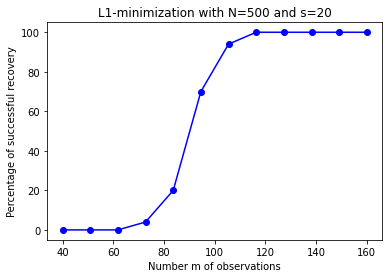

In [8]:
N = 500
s = 20
m_min = 2*s
m_max = 8*s
m_inc = 10
n_tests = 100
res = np.zeros( (n_tests,int((m_max-m_min)/m_inc)) )
for m in range(m_min,m_max,m_inc):
    for t in range(n_tests):
        x = np.zeros(N)
        supp = np.sort(np.random.permutation(N)[:s])
        x[supp] = np.random.normal(0,1,s)
        A = np.sqrt(np.pi/2)/m*np.random.normal(0,1,size=(m,N))
        y = A@x
        xstar = cp.Variable(N)
        objective = cp.Minimize(cp.norm(xstar,1))
        constraints = [A@xstar==y]
        l1_min = cp.Problem(objective,constraints)
        l1_min.solve(solver='SCS')
        xstar = xstar.value
        res[t,int((m-m_min)/m_inc)] = ( LA.norm(x-xstar) < 5e-4*LA.norm(x) )
plt.plot(np.linspace(m_min,m_max,int((m_max-m_min)/m_inc)),100*np.mean(res,axis=0),'b-o')
plt.xlabel('Number m of observations')
plt.ylabel('Percentage of successful recovery')
plt.title('L1-minimization with N=' +str(N) +' and s=' +str(s))
plt.show()